# Categorical Regression

In this example, we will use the categorical family to model outcomes with more than two categories. The examples in this notebook were constructed by Tomás Capretto, and assembled into this example by Tyler James Burch ([\@tjburch](https://github.com/tjburch) on GitHub).

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")

When modeling binary outcomes with Bambi, the Bernoulli family is used. The multivariate generalization of the Bernoulli family is the Categorical family, and with it, we can model an arbitrary number of outcome categories. 

## Example with toy data

To start, we will create a toy dataset with three classes.

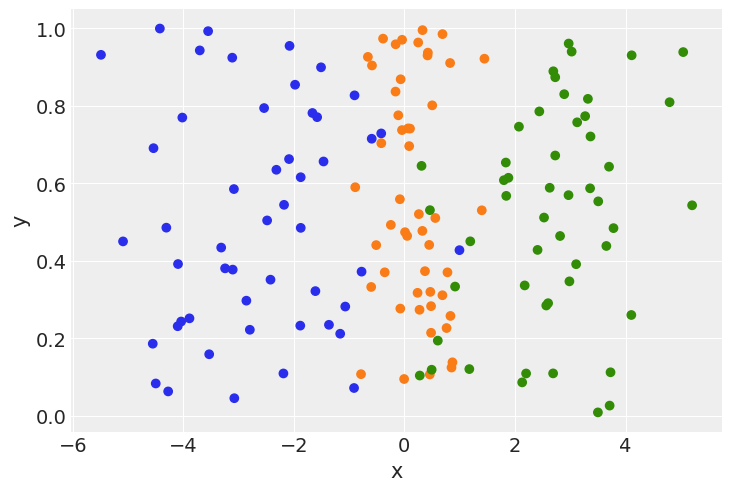

In [2]:
rng = np.random.default_rng(1234)
x = np.hstack([rng.normal(m, s, size=50) for m, s in zip([-2.5, 0, 2.5], [1.2, 0.5, 1.2])])
y = np.array(["A"] * 50 + ["B"] * 50 + ["C"] * 50)

colors = ["C0"] * 50 + ["C1"] * 50 + ["C2"] * 50
plt.scatter(x, np.random.uniform(size=150), color=colors)
plt.xlabel("x")
plt.ylabel("y");

Here we have 3 classes, generated from three normal distributions: $N(-2.5, 1.2)$, $N(0, 0.5)$, and $N(2.5, 1.2)$. Creating a model to fit these distributions,

In [3]:
data = pd.DataFrame({"y": y, "x": x})
model = bmb.Model("y ~ x", data, family="categorical")
idata = model.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Note that we pass the `family="categorical"` argument to Bambi's `Model` method in order to call the categorical family. Here, the response variable are strings ("A", "B", "C"), however they can also be `pd.Categorical` objects.

Next we will use posterior predictions to visualize the mean class probability across the $x$ spectrum.
To do this, we simply call [bmb.interpret.plot_predictions](https://bambinos.github.io/bambi/notebooks/plot_predictions.html) and specify that the computations should be conditional on $x$. Then, the function does all the work for us.

Default computed for conditional variable: x


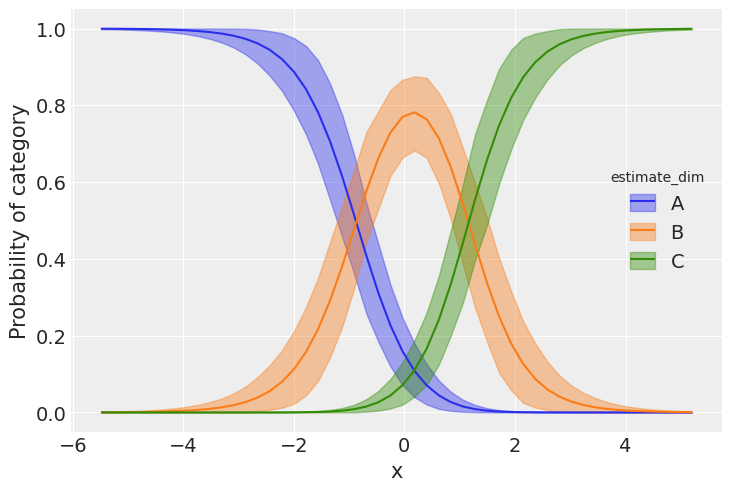

In [10]:
fig, ax = bmb.interpret.plot_predictions(model, idata, conditional="x")
ax[0].set(ylabel="Probability of category");

If we want a more elaborate figure, we can tweak the function arguments like this:

Default computed for conditional variable: x


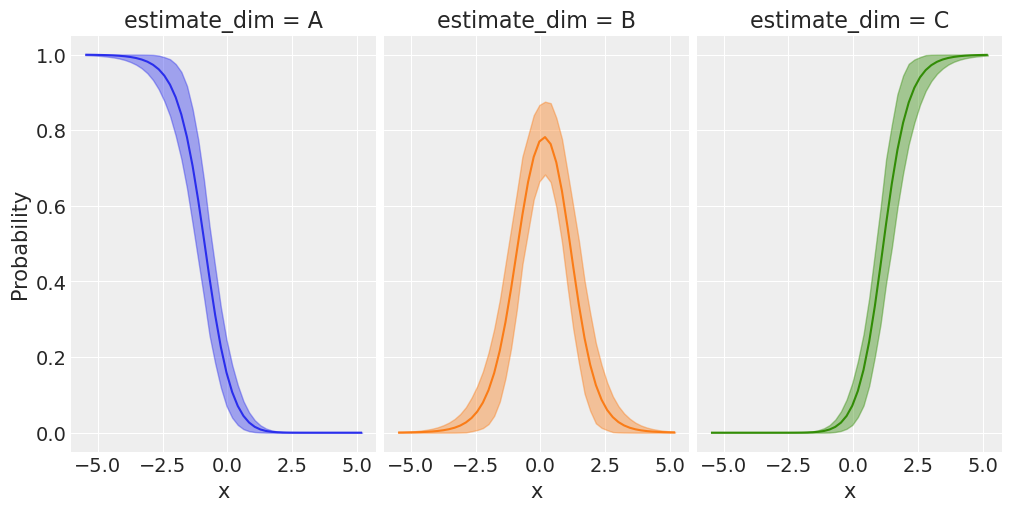

In [13]:
fig, ax = bmb.interpret.plot_predictions(
    model,
    idata,
    conditional="x",
    legend=False,
    subplot_kwargs={"main": "x", "group": "estimate_dim", "panel": "estimate_dim"},
    fig_kwargs={"figsize": (10, 5), "sharey": True}
)
ax[0].set(ylabel="Probability")
ax[1].set(ylabel=None)
ax[2].set(ylabel=None);

Here, we can notice that the probability phases between classes from left to right. At all points across $x$, sum of the class probabilities is 1, since in our generative model, it must be one of these three outcomes.  

## The iris dataset

Next, we will look at the classic "iris" dataset, which contains samples from 3 different species of iris plants. Using properties of the plant, we will try to model its species.

In [5]:
df_iris = pd.read_csv("data/iris.csv")
df_iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa


The dataset includes four different properties of the plants: it's sepal length, sepal width, petal length, and petal width. There are 3 different class possibilities: setosa, versicolor, and virginica.

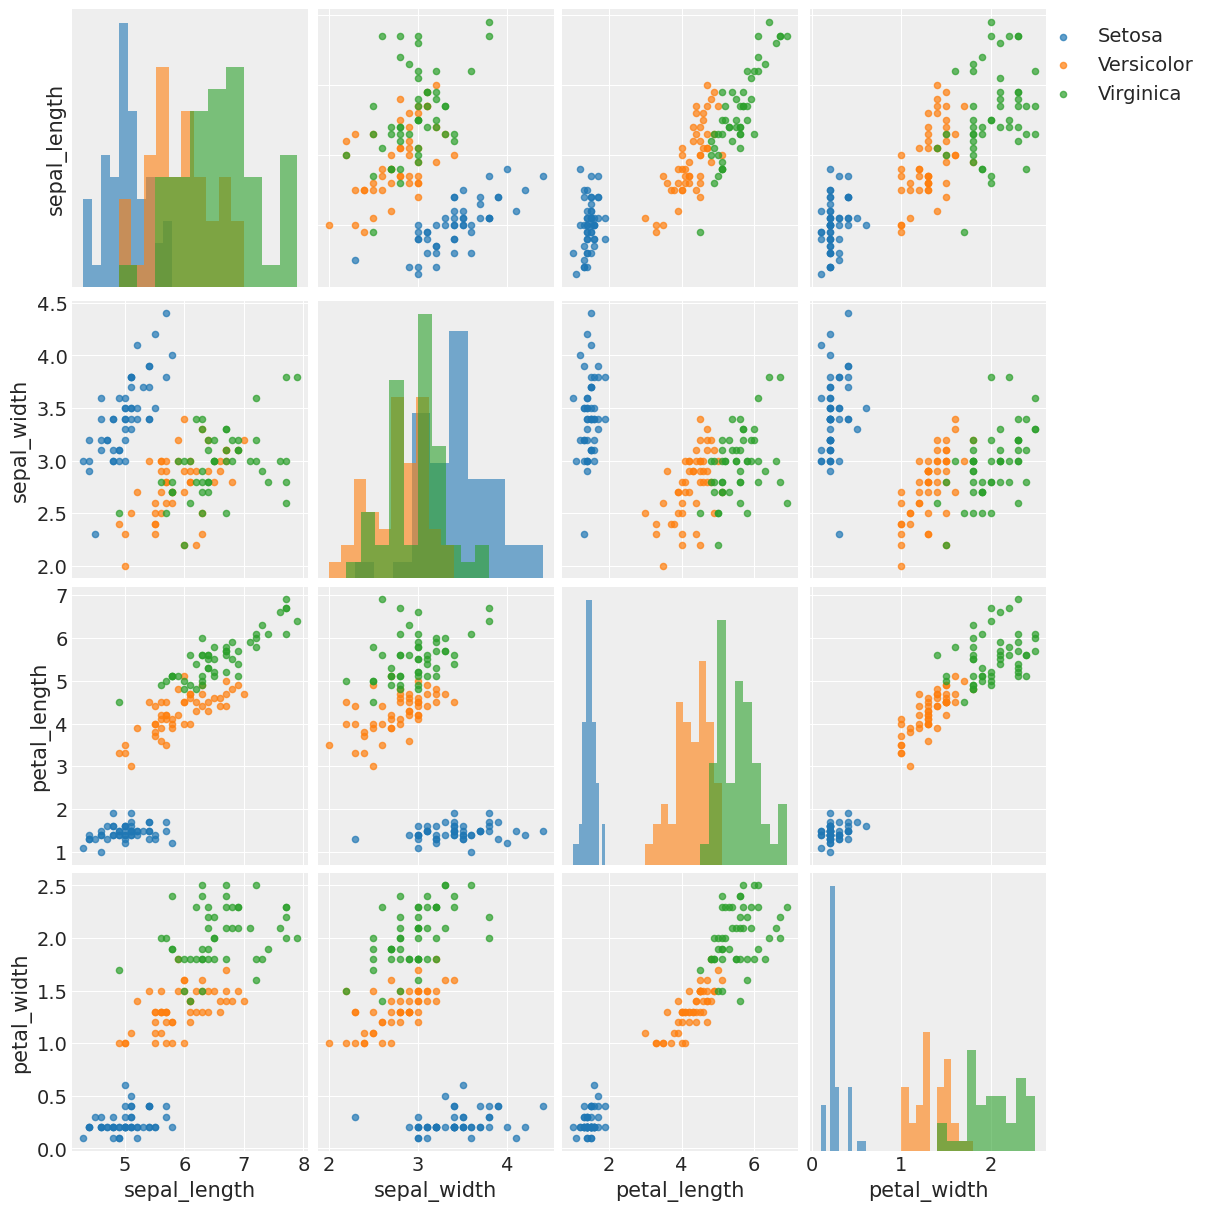

In [6]:
#| code-fold: true
features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
n_features = len(features)
species_list = df_iris["species"].unique()
colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, axes = plt.subplots(n_features, n_features, figsize=(12, 12))
for i, feat_i in enumerate(features):
    for j, feat_j in enumerate(features):
        ax = axes[i, j]
        if i == j:
            for sp, c in zip(species_list, colors):
                ax.hist(df_iris[df_iris['species'] == sp][feat_i], alpha=0.6, label=sp, color=c)
                ax.set(yticks=[])
            if i == n_features - 1:
                ax.set_xlabel(feat_j)
            else:
                ax.set(xticks=[])
            if j == 0:
                ax.set_ylabel(feat_i)
        else:
            for sp, c in zip(species_list, colors):
                subset = df_iris[df_iris['species'] == sp]
                ax.scatter(subset[feat_j], subset[feat_i], alpha=0.7, s=20, color=c, label=sp)
            if i == n_features - 1:
                ax.set_xlabel(feat_j)
            else:
                ax.set_xticklabels([])
            if j == 0:
                ax.set_ylabel(feat_i)
            else:
                ax.set_yticklabels([])

axes[0, -1].legend(loc='upper right', bbox_to_anchor=(1.7, 1));

We can see the three species have several distinct characteristics, which our linear model can capture to distinguish between them.

In [7]:
model = bmb.Model(
    "species ~ sepal_length + sepal_width + petal_length + petal_width",
    df_iris,
    family="categorical",
)
idata = model.fit()
az.summary(idata)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, sepal_length, sepal_width, petal_length, petal_width]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[Versicolor],-6.599,8.216,-21.918,9.335,0.159,0.132,2683.0,2641.0,1.0
Intercept[Virginica],-22.344,9.810,-42.471,-6.044,0.184,0.159,2887.0,2374.0,1.0
sepal_length[Versicolor],3.060,1.723,-0.174,6.342,0.038,0.027,2112.0,2248.0,1.0
sepal_length[Virginica],2.296,1.773,-0.960,5.658,0.039,0.029,2040.0,2197.0,1.0
sepal_width[Versicolor],-4.709,1.941,-8.241,-0.974,0.041,0.032,2314.0,2690.0,1.0
sepal_width[Virginica],-6.616,2.309,-10.885,-2.156,0.047,0.034,2381.0,2788.0,1.0
petal_length[Versicolor],1.091,0.910,-0.738,2.686,0.017,0.015,2764.0,2593.0,1.0
petal_length[Virginica],3.992,1.069,2.043,5.997,0.019,0.016,3051.0,2803.0,1.0
petal_width[Versicolor],1.927,2.055,-1.777,5.933,0.039,0.037,2772.0,2518.0,1.0
petal_width[Virginica],9.046,2.292,5.104,13.673,0.043,0.034,2914.0,2451.0,1.0


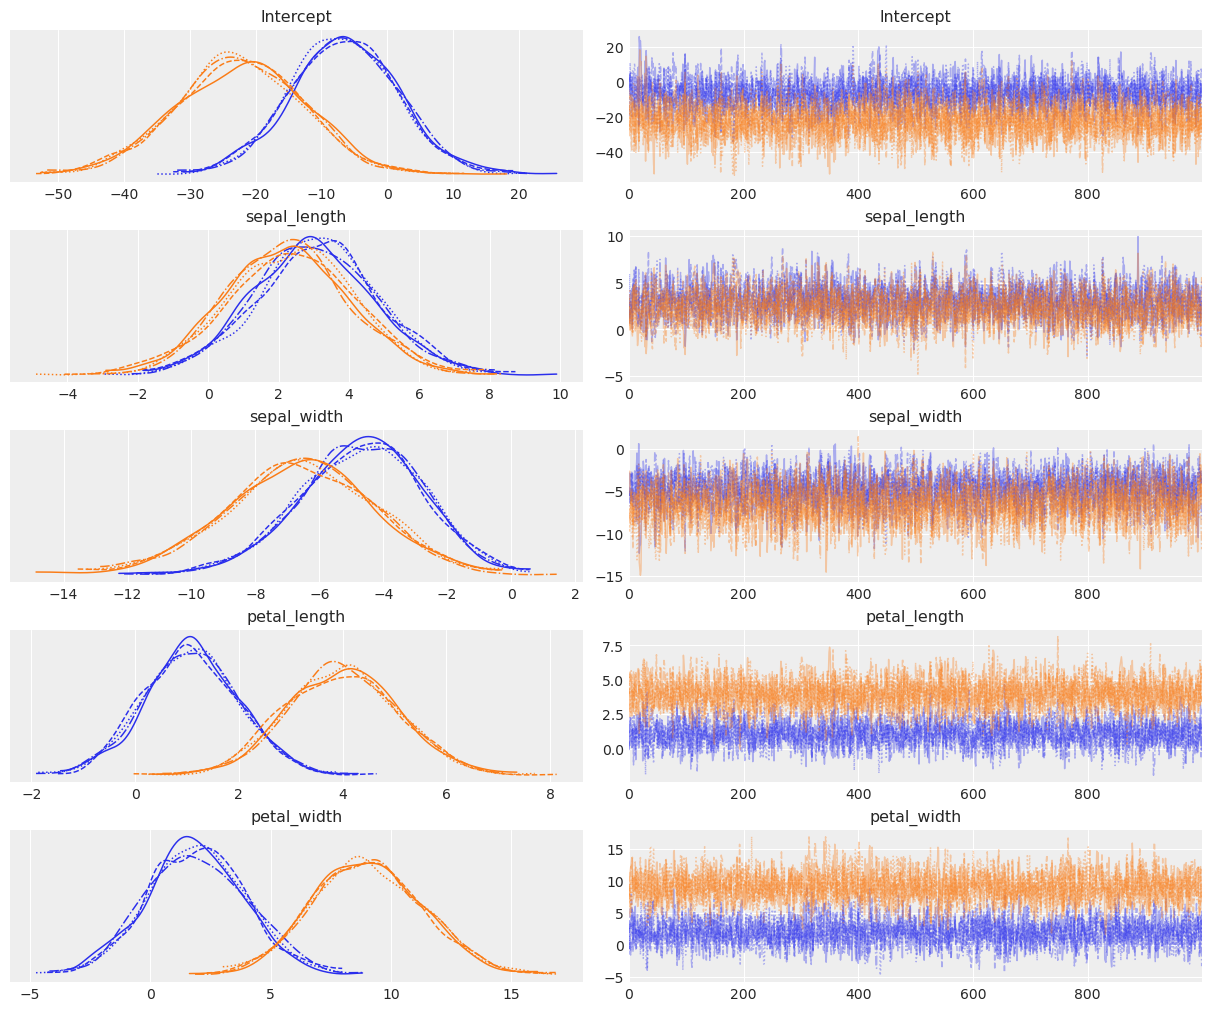

In [8]:
az.plot_trace(idata);

We can see that this has fit quite nicely. You'll notice there are $n-1$ parameters to fit, where $n$ is the number of categories. In the minimal binary case, recall there's only one parameter set, since it models probability $p$ of being in a class, and probability $1-p$ of being in the other class. Using the categorical distribution, this extends, so we have $p_1$ for class 1, $p_2$ for class 2, and $1-(p_1+p_2)$ for the final class.

## Using numerical and categorical predictors

Next we will look at an example from chapter 8 of Alan Agresti's _Categorical Data Analysis_, looking at the primary food choice for 64 alligators caught in Lake George, Florida. We will use their length (a continuous variable) and sex (a categorical variable) as predictors to model their food choice.

First, reproducing the dataset,

In [9]:
length = [
    1.3, 1.32, 1.32, 1.4, 1.42, 1.42, 1.47, 1.47, 1.5, 1.52, 1.63, 1.65, 1.65, 1.65, 1.65,
    1.68, 1.7, 1.73, 1.78, 1.78, 1.8, 1.85, 1.93, 1.93, 1.98, 2.03, 2.03, 2.31, 2.36, 2.46,
    3.25, 3.28, 3.33, 3.56, 3.58, 3.66, 3.68, 3.71, 3.89, 1.24, 1.3, 1.45, 1.45, 1.55, 1.6,
    1.6, 1.65, 1.78, 1.78, 1.8, 1.88, 2.16, 2.26, 2.31, 2.36, 2.39, 2.41, 2.44, 2.56, 2.67,
    2.72, 2.79, 2.84
]
choice = [
    "I", "F", "F", "F", "I", "F", "I", "F", "I", "I", "I", "O", "O", "I", "F", "F",
    "I", "O", "F", "O", "F", "F", "I", "F", "I", "F", "F", "F", "F", "F", "O", "O",
    "F", "F", "F", "F", "O", "F", "F", "I", "I", "I", "O", "I", "I", "I", "F", "I",
    "O", "I", "I", "F", "F", "F", "F", "F", "F", "F", "O", "F", "I", "F", "F"
]

sex = ["Male"] * 32 + ["Female"] * 31
data = pd.DataFrame({"choice": choice, "length": length, "sex": sex})
data["choice"]  = pd.Categorical(
    data["choice"].map({"I": "Invertebrates", "F": "Fish", "O": "Other"}),
    ["Other", "Invertebrates", "Fish"],
    ordered=True
)
data.head(3)

,choice,length,sex
0,Invertebrates,1.30,Male
1,Fish,1.32,Male
2,Fish,1.32,Male


Next, constructing the model,

In [10]:
model = bmb.Model("choice ~ length + sex", data, family="categorical")
idata = model.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, length, sex]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Using [bmb.interpret.plot_predictions](https://bambinos.github.io/bambi/notebooks/plot_predictions.html), we can visualize how the probability of the different response levels varies conditional on a set of predictors. In the plot below, we visualize how the food choices vary by length for both male and female alligators. Note how `estimate_dim` (the response level) is mapped as the value to the `group` key.

Default computed for conditional variable: length, sex


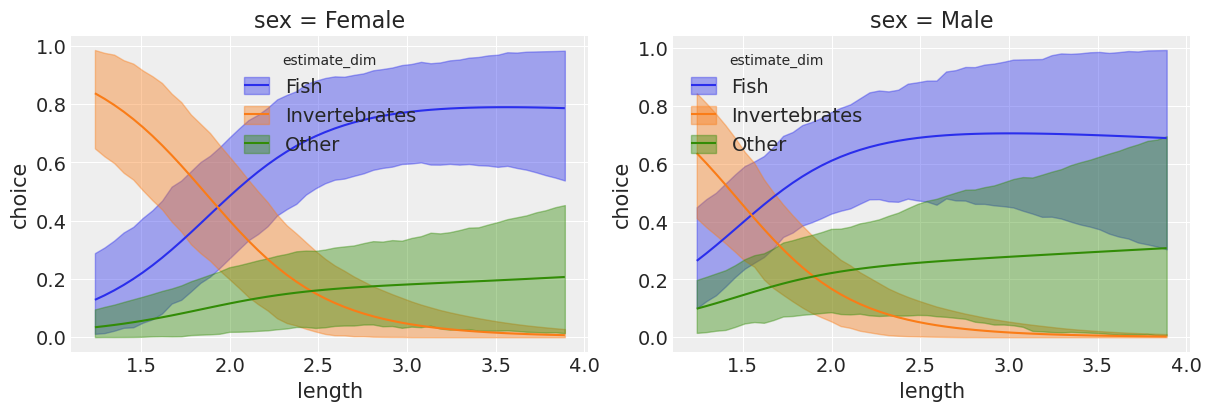

In [11]:
bmb.interpret.plot_predictions(
    model,
    idata,
    ["length", "sex"],
    subplot_kwargs={"main": "length", "group": "estimate_dim", "panel": "sex"},
    fig_kwargs={"figsize": (12, 4)},
    legend=True
);

Here we can see that the larger male and female alligators are, the less of a taste they have for invertebrates, and far prefer fish. Additionally, males seem to have a higher propensity to consume "other" foods compared to females at any size. Of note, the posterior means predicted by Bambi contain information about all $n$ categories (despite having only $n-1$ coefficients), so we can directly construct this plot, rather than manually calculating $1-(p_1+p_2)$ for the third class.

Last, we can make a posterior predictive plot,

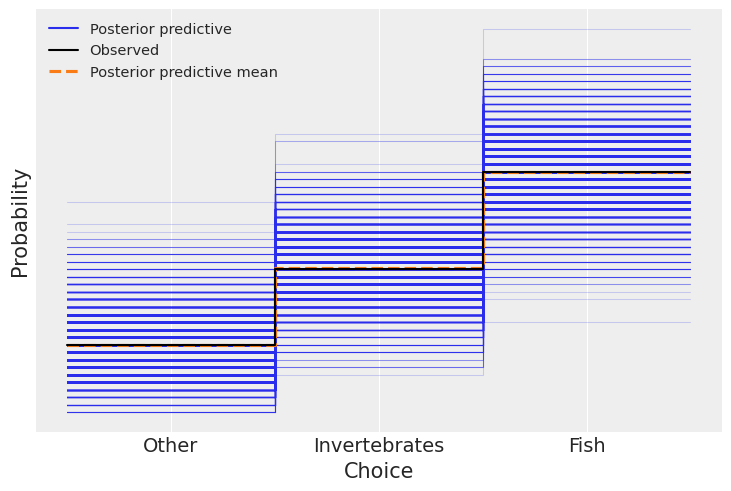

In [12]:
model.predict(idata, kind="pps")

ax = az.plot_ppc(idata)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(model.response_component.term.levels)
ax.set_xlabel("Choice");
ax.set_ylabel("Probability");

which depicts posterior predicted probability for each possible food choice for an alligator, which reinforces fish being the most likely food choice, followed by invertebrates.

### References

Agresti, A. (2013) Categorical Data Analysis. 3rd Edition, John Wiley & Sons Inc., Hoboken.

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 28 2025

Python implementation: CPython
Python version       : 3.13.7
IPython version      : 9.4.0

numpy     : 2.3.3
matplotlib: 3.10.6
arviz     : 0.22.0
pandas    : 2.3.2
bambi     : 0.14.1.dev56+gd93591cd2.d20250927

Watermark: 2.5.0

